Universidade Federal da Paraíba<br>
Centro de Informática<br>
Bacharelado em Ciência de Dados e Inteligência Artificial<br>
Disciplina: Processamento de Linguagem Natural<br>
Docente: Yuri Malheiros<br>
Discente: Maxwel de Andrade Barbosa<br>


<center> <h3> Fine-Tuning de um modelo DistilBERT para análise de sentimentos em avaliações de filmes

## Importação dos dados

In [15]:
import pandas as pd

df = pd.read_csv('IMDB Dataset.csv')

## Descrição do dataset

### Visão Geral
- **Objetivo**: Classificação binária de sentimento em avaliações de filmes.
- **Link**: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews  


### Arquivo
- **Nome**: `IMDB Dataset.csv`  
- **Linhas**: 50.000  
- **Colunas**: 2

### Colunas
| Nome       | Descrição                                   | Tipo    |
|------------|---------------------------------------------|---------|
| `review`   | Texto completo da avaliação do usuário.     | String  |
| `sentiment`| Rótulo de sentimento (“positive”/“negative”).| String  |

## Exploração inicial do dataset

In [16]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [17]:
#exibindo as dimensões do dataset
df.shape

(50000, 2)

In [18]:
#exibindo a quantidade de classes
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Verificando a frequência das palavras do dataset

In [19]:
from collections import Counter

# juntando todas as reviews em uma única string
all_reviews = ' '.join(df['review'].astype(str))

# tokenizando as reviews
tokens = all_reviews.lower().split()

# usando Counter para contar a frequência de cada token
token_counts = Counter(tokens)

# obtendo os 20 tokens mais comuns e suas contagens
top_20_tokens = token_counts.most_common(20)

# exibindo os 20 tokens mais comuns
top_20_tokens


[('the', 638861),
 ('a', 316615),
 ('and', 313637),
 ('of', 286661),
 ('to', 264573),
 ('is', 204876),
 ('in', 179807),
 ('i', 141587),
 ('this', 138483),
 ('that', 130140),
 ('it', 129614),
 ('/><br', 100974),
 ('was', 93258),
 ('as', 88242),
 ('with', 84590),
 ('for', 84510),
 ('but', 77864),
 ('on', 62890),
 ('movie', 61492),
 ('are', 57009)]

## Pré-processamento dos dados utilizando NLP

In [20]:
# convertendo todos as letras pra minúsculas
df['review'] = df['review'].str.lower()

Utilizando regex para remover caracteres indesejados do conjunto de dados como `<br /><br />` , `\x85`, `\t` e `\xa0`

In [21]:
import re

# Função para aplicar a regex
def clean_text(text):
    # Substitui "<br /><br />" por ""
    text = re.sub(r'<br\s*/?>', '', text)

    # Mantém apenas a-z, A-Z e 0-9, e remove qualquer outro caractere
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # remove '\x85' , '\t' e '\xa0'
    text = re.sub(r'[\x85\t\xa0]', '', text)

    return text

In [22]:
# antes de aplicar o pré-processamento
df['review'][1]

'a wonderful little production. <br /><br />the filming technique is very unassuming- very old-time-bbc fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />the actors are extremely well chosen- michael sheen not only "has got all the polari" but he has all the voices down pat too! you can truly see the seamless editing guided by the references to williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. a masterful production about one of the great master\'s of comedy and his life. <br /><br />the realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. it plays on our knowledge and our senses, particularly with the scenes concerning orton and halliwell and the sets (particularly of their flat with halliwell\'s murals decorating every surface) are terribly well d

In [23]:
# aplicando a função nos reviews
df['review'] = df['review'].apply(clean_text)

In [24]:
# após aplicar o pré-processamento
df['review'][1]

'a wonderful little production the filming technique is very unassuming very oldtimebbc fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece the actors are extremely well chosen michael sheen not only has got all the polari but he has all the voices down pat too you can truly see the seamless editing guided by the references to williams diary entries not only is it well worth the watching but it is a terrificly written and performed piece a masterful production about one of the great masters of comedy and his life the realism really comes home with the little things the fantasy of the guard which rather than use the traditional dream techniques remains solid then disappears it plays on our knowledge and our senses particularly with the scenes concerning orton and halliwell and the sets particularly of their flat with halliwells murals decorating every surface are terribly well done'

Verificando a frequência de caracteres que não são letras após o a aplicação do regex para verificar se sobrou algo que deveria ser removido

In [25]:
# combinando todas as reviews em uma única string
all_reviews = ' '.join(df['review'].astype(str))

# usando regex para encontrar todos os caracteres que não são letras minúsculas
non_lowercase_chars = re.findall(r'[^a-z]', all_reviews.lower())

# usando Counter para contar a frequência de cada caractere não minúsculo
non_lowercase_counts = Counter(non_lowercase_chars)

# exibindo os resultados
non_lowercase_counts

Counter({' ': 11355348,
         '0': 37357,
         '1': 35792,
         '9': 19392,
         '2': 15978,
         '3': 11002,
         '5': 10457,
         '8': 8874,
         '4': 8342,
         '7': 8277,
         '6': 6209})

Como sobraram apenas caracteres numéricos e espaço, podemos prosseguir com a implementação.

<div style="text-align: center;">
    <img src="fine-tuning.jpg" width="900">
</div>

### Reduzindo o dataset de 50k para 2K de exemplos visando eficiência computacional, evitar overfitting e garantir equilíbrio entre classes, mantendo a diversidade dos dados.

In [26]:
import pandas as pd

# dividindo os dados por classe
positive_reviews = df[df['sentiment'] == 'positive']
negative_reviews = df[df['sentiment'] == 'negative']

# selecionando aleatoriamente 1000 registros de cada classe
positive_sample = positive_reviews.sample(n=1000, random_state=42)
negative_sample = negative_reviews.sample(n=1000, random_state=42)

# combinando as duas amostras
df = pd.concat([positive_sample, negative_sample])

# embaralhando o novo dataframe para garantir aleatoriedade
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# exibindo as dimensões do novo dataset
print(df.shape)

# exibindo a contagem de cada classe no novo dataset
df['sentiment'].value_counts()

(2000, 2)


sentiment
negative    1000
positive    1000
Name: count, dtype: int64

### Dividindo o dataset em 80% para treino, 10% para teste e 10% para validação

In [27]:
from sklearn.model_selection import train_test_split

# Dividindo os dados em conjuntos de treinamento (80%), teste (10%) e validação (10%)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# imprimindo as dimensões dos conjuntos de dados resultantes
print("Training set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
print("Testing set shape:", test_df.shape)

Training set shape: (1600, 2)
Validation set shape: (200, 2)
Testing set shape: (200, 2)


In [28]:
!pip install transformers torch accelerate --quiet

In [29]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

# carregando o tokenizer e modelo
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



A tokenização é essencial para converter os textos em representações numéricas que o modelo DistilBERT pode processar.
Neste caso, os reviews são transformados em IDs correspondentes ao vocabulário do modelo, garantindo que:
- Os textos sejam convertidos para um formato que o modelo entende;
- Seja aplicada a padronização do tamanho das sequências por meio de padding e truncation (limitado a 512 tokens) para facilitar o processamento em lotes;
- A saída seja retornada como tensores (com return_tensors="pt"), compatíveis com o PyTorch para treinamento e inferência.


In [30]:
def tokenize_data(texts, labels, max_length=512):
    return tokenizer(
        texts.tolist(),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

# tokenizando os dados de treino, validação e teste
train_encodings = tokenize_data(train_df['review'], train_df['sentiment'])
val_encodings = tokenize_data(val_df['review'], val_df['sentiment'])
test_encodings = tokenize_data(test_df['review'], test_df['sentiment'])

O PyTorch requer que os dados sejam convertidos para tensores para que o modelo possa ser treinado. Aqui estamos convertendo tanto os dados de entrada quanto os rótulos para o formato de tensor necessário para o treinamento

In [31]:
# convertendo as labels para valores numéricos (0 = negative, 1 = positive)
label_mapping = {"negative": 0, "positive": 1}
train_labels = torch.tensor(train_df['sentiment'].map(label_mapping).values)
val_labels = torch.tensor(val_df['sentiment'].map(label_mapping).values)
test_labels = torch.tensor(test_df['sentiment'].map(label_mapping).values)

`DataLoader` é utilizado no PyTorch para carregar os dados em batches durante o treinamento. Dividimos os dados em lotes, o que ajuda a treinar o modelo de forma mais eficiente. Aqui, o parâmetro `shuffle = True` garante que os dados de treino sejam embaralhados a cada época.

O `TensorDataset` é utilizado para combinar múltiplos tensores em um único dataset, permitindo que os dados de entrada (como `input_ids` e `attention_mask`) e os rótulos (`labels`) sejam agrupados e acessados de forma sincronizada. Isso é essencial para o treinamento e avaliação do modelo, pois garante que cada exemplo no dataset contenha todas as informações necessárias para o processamento em lotes (`DataLoader`), facilitando a manipulação e o treinamento eficiente do modelo.

In [18]:
from torch.utils.data import TensorDataset, DataLoader

# criando os TensorDatasets
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

# criando os DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

1. **Configuração do Otimizador**:
    - O otimizador escolhido é o `AdamW`, que é amplamente utilizado em modelos de aprendizado profundo, especialmente em Transformers. Ele combina a eficiência do algoritmo Adam com regularização por decaimento de peso (`weight decay`), ajudando a evitar overfitting.
    - A taxa de aprendizado (`lr`) é configurada como `2e-5`, um valor comum para fine-tuning de modelos pré-treinados como o DistilBERT.

2. **Seleção do Dispositivo**:
    - O código verifica se uma GPU está disponível utilizando `torch.cuda.is_available()`. Caso esteja, o dispositivo será configurado como `"cuda"`, caso contrário, será `"cpu"`.
    - O uso de GPU acelera significativamente o treinamento e a inferência, especialmente em modelos grandes como o DistilBERT.

3. **Movendo o Modelo para o Dispositivo**:
    - O modelo é transferido para o dispositivo selecionado (GPU ou CPU) utilizando o método `.to(device)`. Isso garante que os cálculos sejam realizados no hardware apropriado, otimizando o desempenho.

Essas etapas são fundamentais para preparar o modelo e o ambiente para o treinamento eficiente e correto.

In [19]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5) # configurando o otimizador AdamW com taxa de aprendizado de 2e-5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # verificando se há uma GPU disponível, caso contrário, usa a CPU

model.to(device) # movendo o modelo para o dispositivo selecionado (GPU ou CPU)
print(f"Using device: {device}") #exibindo o disposito usado

Using device: cuda


100%|██████████| 50/50 [01:09<00:00,  1.38s/it]


Epoch 1:
  Train Loss: 0.5622
  Val Loss: 0.4220
  Train Accuracy: 0.7056
  Val Accuracy: 0.8050


100%|██████████| 50/50 [01:12<00:00,  1.45s/it]


Epoch 2:
  Train Loss: 0.2775
  Val Loss: 0.2867
  Train Accuracy: 0.8900
  Val Accuracy: 0.8850


100%|██████████| 50/50 [01:12<00:00,  1.44s/it]


Epoch 3:
  Train Loss: 0.1473
  Val Loss: 0.3065
  Train Accuracy: 0.9544
  Val Accuracy: 0.8950


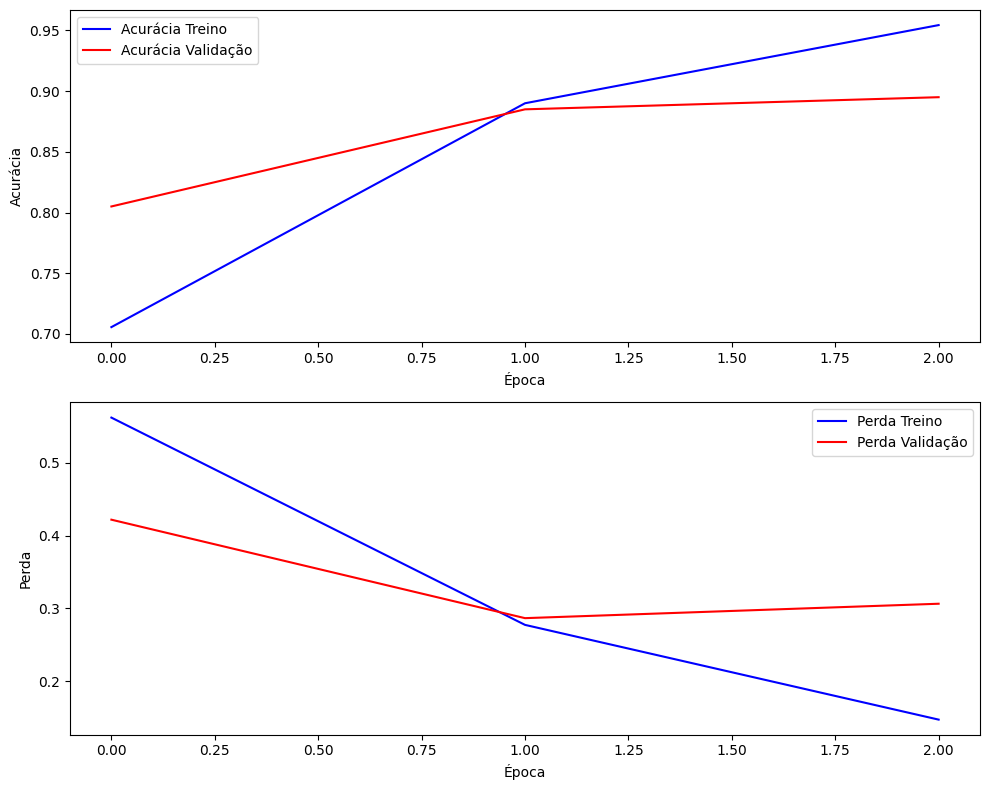

In [20]:
from tqdm import tqdm  # importa a biblioteca tqdm para mostrar barras de progresso
import plotly.graph_objects as go  # importa a biblioteca plotly para gráficos
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, epochs=3):  # define função para treinar o modelo
    # Listas para armazenar as perdas e acurácias
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    epochs_range = list(range(epochs))

    for epoch in range(epochs):  # loop através das épocas de treinamento
        # treino
        model.train()  # coloca o modelo em modo de treinamento
        train_loss = 0  # inicializa a variável para acumular a perda de treino
        correct_train = 0  # inicializa contador de previsões corretas de treino

        for batch in tqdm(train_loader):  # itera sobre os lotes de treino com barra de progresso
            input_ids, attention_mask, labels = [b.to(device) for b in batch]  # move os dados para o dispositivo (GPU/CPU)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)  # faz a forward pass
            loss = outputs.loss  # obtém o valor da perda
            loss.backward()  # faz a backward pass para calcular gradientes
            optimizer.step()  # atualiza os parâmetros do modelo
            optimizer.zero_grad()  # zera os gradientes para a próxima iteração
            train_loss += loss.item()  # acumula a perda de treino
            preds = torch.argmax(outputs.logits, dim=1)  # obtém as previsões do modelo
            correct_train += (preds == labels).sum().item()  # conta as previsões corretas de treino

        # Validação
        model.eval()  # coloca o modelo em modo de avaliação
        val_loss = 0  # inicializa a variável para acumular a perda de validação
        correct_val = 0  # inicializa contador de previsões corretas de validação

        with torch.no_grad():  # desabilita o cálculo de gradientes para validação
            for batch in val_loader:  # itera sobre os lotes de validação
                input_ids, attention_mask, labels = [b.to(device) for b in batch]  # move os dados para o dispositivo
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)  # faz a forward pass
                val_loss += outputs.loss.item()  # acumula a perda de validação
                preds = torch.argmax(outputs.logits, dim=1)  # obtém as previsões do modelo
                correct_val += (preds == labels).sum().item()  # conta as previsões corretas de validação

        # Armazenando as métricas
        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        train_accuracies.append(correct_train / len(train_loader.dataset))
        val_accuracies.append(correct_val / len(val_loader.dataset))

        # Imprime as métricas para cada época
        print(f"Epoch {epoch+1}:")  # imprime o número da época
        print(f"  Train Loss: {train_loss/len(train_loader):.4f}")  # imprime a perda média de treino
        print(f"  Val Loss: {val_loss/len(val_loader):.4f}")  # imprime a perda média de validação
        print(f"  Train Accuracy: {train_accuracies[-1]:.4f}")  # imprime a acurácia de treino
        print(f"  Val Accuracy: {val_accuracies[-1]:.4f}")  # imprime a acurácia de validação

    # Gerando os gráficos de Acurácia e Perda
    plt.figure(figsize=(10, 8))

    # Gráfico de Acurácia
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, train_accuracies, label='Acurácia Treino', color='blue')
    plt.plot(epochs_range, val_accuracies, label='Acurácia Validação', color='red')  # alterado para vermelho
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()

    # Gráfico de Perda
    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, train_losses, label='Perda Treino', color='blue')
    plt.plot(epochs_range, val_losses, label='Perda Validação', color='red')  # alterado para vermelho
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()

    plt.tight_layout()
    plt.show()

# executando o treinamento
train_model(model, train_loader, val_loader, epochs=3)  # chama a função para treinar o modelo

In [21]:
model.eval() # coloca o modelo em modo de avaliação (desativa camadas como dropout)

test_correct = 0 # inicializa contador para armazenar o número de previsões corretas

with torch.no_grad(): # desabilita cálculo de gradientes para economizar memória e computação
    for batch in test_loader: # itera sobre os lotes de dados de teste
        input_ids, attention_mask, labels = [b.to(device) for b in batch] # move os tensores do batch para o dispositivo (GPU/CPU)
        outputs = model(input_ids, attention_mask=attention_mask) # realiza a forward pass do modelo (obtém as previsões)
        preds = torch.argmax(outputs.logits, dim=1) # obtém as classes previstas (índices com maior valor nos logits)
        test_correct += (preds == labels).sum().item() # conta quantas previsões estão corretas e acumula no total

print(f"Acurácia no Teste: {test_correct/len(test_dataset):.2f}")

Acurácia no Teste: 0.89


In [22]:
model.save_pretrained("distilbert-base-uncased")
tokenizer.save_pretrained("distilbert-base-uncased")

('distilbert-base-uncased/tokenizer_config.json',
 'distilbert-base-uncased/special_tokens_map.json',
 'distilbert-base-uncased/vocab.txt',
 'distilbert-base-uncased/added_tokens.json')

In [23]:
def display_classification_examples(test_loader, model, tokenizer, device):
    """
    Exibe o primeiro exemplo classificado corretamente e o primeiro exemplo classificado incorretamente.

    Args:
        test_loader (DataLoader): DataLoader do conjunto de teste.
        model (torch.nn.Module): Modelo treinado.
        tokenizer (PreTrainedTokenizer): Tokenizador usado no modelo.
        device (torch.device): Dispositivo (CPU ou GPU).
    """
    model.eval()
    correct_example = None
    incorrect_example = None

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            for i in range(len(labels)):
                review = tokenizer.decode(input_ids[i], skip_special_tokens=True)
                label = labels[i].item()
                prediction = preds[i].item()

                if label == prediction and correct_example is None:
                    correct_example = (review, label, prediction)
                elif label != prediction and incorrect_example is None:
                    incorrect_example = (review, label, prediction)

                if correct_example and incorrect_example:
                    break
            if correct_example and incorrect_example:
                break

    if correct_example:
        review, label, prediction = correct_example
        print(f"Exemplo classificado corretamente:\nReview: {review}\nClasse verdadeira: {label} | Classe predita: {prediction}\n")
    else:
        print("Nenhum exemplo classificado corretamente encontrado.\n")

    if incorrect_example:
        review, label, prediction = incorrect_example
        print(f"Exemplo classificado incorretamente:\nReview: {review}\nClasse verdadeira: {label} | Classe predita: {prediction}\n")
    else:
        print("Nenhum exemplo classificado incorretamente encontrado.\n")


In [24]:
display_classification_examples(test_loader, model, tokenizer, device)

Exemplo classificado corretamente:
Review: i had high hopes for this one after reading earlier reviews but it was so slow and the plot so basic that well i wondered if i had read the wrong reviews please a boy meets girl next door at 11 and both aspire to love and being basketball legends grow apart but watch each others progress guess what both get scholarships to same university and become lovers again until his father is caught out playing around with a younger woman our young hero unable to cope has lapse in court concentration but some how decides to go pro and drop studies and guess what is picked up by lakers dumps the heroine because she was not there for him during this emotional period so for 5 years they go their own way she returns from spain having lost the zest for the game and our hero is getting married in two weeks mom tells her that she should fight for her love so she professes her ongoing love and challenges him to a basketball shootout he wins he marries she wins h

Matriz de confusão

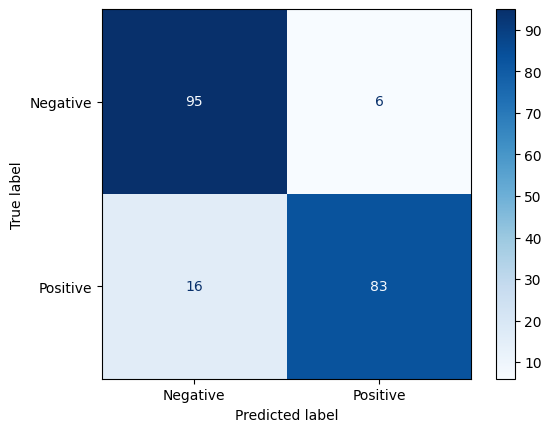

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# colocando o modelo em modo de avaliação
model.eval()

# obtendo as previsões no conjunto de teste
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# calculando a matriz de confusão
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])

# exibindo a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")